In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import re
from typing import List, Dict

from collections import namedtuple, Counter
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from itertools import product
from scipy.stats import spearmanr, kendalltau

from scipy.special import expit
from IPython.core.display import HTML, display

## Посмотреть данные

### Отобрать нужные записи из results

In [2]:
%%time

Records = namedtuple("Records", ("tournament_id", "t_start_date", "team_ind", "team_id", "players", "mask",
                                "team_position"))

# получить словарь results с нужными результатами
def get_results_dictionary():
    """получить нужные записи из results"""
    with open("results.pkl", 'rb') as f:
        results_raw = pickle.load(f)

    results = {}

    for key, lst in results_raw.items():
        for lst_el in lst:
            if 'mask' in lst_el and lst_el['mask'] is not None \
                    and 'teamMembers' in lst_el and lst_el['teamMembers']:
                results[key] = lst
    return results
            
def get_tournaments_start_dates():
    """получить даты начала турниров из tournaments"""
    with open("tournaments.pkl", 'rb') as f:
        tournaments_data = pickle.load(f)

    tournaments_data = {key: value for key, value in tournaments_data.items() } # if key in tournaments}

    tournaments_start_dates = {key: value['dateStart'] for key, value in tournaments_data.items()}

    del tournaments_data
    return tournaments_start_dates

tournaments_results = get_results_dictionary()
tournaments_start_dates = get_tournaments_start_dates()


# разделить турниры из results на train и test
plays_train = []
plays_test = []
for tournament_id, lst in tournaments_results.items():
    if lst is not None:
        for team_ind, lst_el in enumerate(lst):
            if lst_el['teamMembers'] is not None and lst_el['mask'] is not None:
                
                team_members = lst_el['teamMembers']
                players = [i['player']['id'] for i in team_members]
                team_id = lst_el['team']['id']
                team_position = lst_el['team']['position'] if 'position' in lst_el['team'] else None
                mask = lst_el['mask']
                start_date = tournaments_start_dates[tournament_id]
                
                if pd.to_datetime(start_date).year == 2019:
                            # and any([i in players_sample_set for i in players]):
                    plays_train.append(Records(tournament_id=tournament_id, 
                                         t_start_date=start_date,
                                         team_ind=team_ind, 
                                         team_id=team_id, 
                                         players=players, 
                                         mask=mask,
                                         team_position=team_position
                                        )
                                )
                elif pd.to_datetime(start_date).year == 2020:
                    plays_test.append(Records(tournament_id=tournament_id, 
                                         t_start_date=start_date,
                                         team_ind=team_ind, 
                                         team_id=team_id, 
                                         players=players, 
                                         mask=mask,
                                         team_position=team_position
                                        )
                                )     
with open("plays_train.pkl", 'wb') as f:
    pickle.dump(plays_train, f)
    
with open("plays_test.pkl", 'wb') as f:
    pickle.dump(plays_test, f)
    
del tournaments_results

Wall time: 1min 19s


## Построить baseline-модель

Для предсказания результатов ответов на вопросы каждого игрока на этапе baseline, мы будем использовать исторические данные по его результатам. (На последующем этапе EM-алгоритма используется другой подход: лог. рег обучается на признаках бинарных признаках игрок-вопрос и сила игрока определяется как коэффициент в логистической регрессии)

__Основные предпосылки:__

- Игрок, в среднем, участвует в турнирах той же сложности в которых он участвовал ранее. Переходы в турниры более высокого уровня сложности происходят постепенно (если происходят)
- Игрок, в среднем, играет в команде того же уровня, что и ранее.
- Модель учитывает данные по всем предыдущим играм.
- X - данные по предыдущим турнирам и их результатам. y - ответы на вопросы в текущей игре. Для каждого значения ответа на вопрос в текущей игре (значение y) на вход модели на этапе обучения будет подаваться одна и та же строка, отражающая результаты предыдущих турниров для данного игрока.
- Для обучающей выборки выбираем один момент времени для каждого игрока, чтобы данные для обучения были максимально независимы. Если данных недостаточно, то можно выбрать и более одного момента для обучения.

### Выбрать моменты для обучения модели

In [3]:
%%time
with open("plays_train.pkl", 'rb') as f:
    plays_train = pickle.load(f)
    
with open("plays_test.pkl", 'rb') as f:
    plays_test = pickle.load(f)

def get_df_by_player_for_plays(plays):
    """взять каждую запись со списком игроков и развернуть её в DataFrame,
       где каждая строка отражает игрока
    """
    df = pd.DataFrame(columns=['player', 'tournament_id', 't_start_date', 'team_id', 'mask'])
    to_concat = []
    for record in tqdm(plays):
        for player in record.players:
            to_append = np.array(
                [
                [player, 
                 record.tournament_id, 
                 record.t_start_date, 
                 record.team_id, 
                 record.mask]
                ]
            )
            to_concat.append(to_append)

    to_concat = np.vstack(to_concat)

    df = pd.DataFrame(to_concat, columns=['player', 'tournament_id', 't_start_date', 'team_id', 'mask'])

    df = df.sort_values(by='player')
    return df

train_df = get_df_by_player_for_plays(plays_train)
test_df = get_df_by_player_for_plays(plays_test)

def add_target_features(df):
    """
    первый шаг предобработки данных
    1) поправить типы 
    2) добавить поле target на основе поля mask
    3) отсортировать турниры игрока в хронологическом порядке
    
    Input:
        df[['player', 'tournament_id', 't_start_date', 'team_id']]
    
    """
    df = df.astype({'player': int,
                                'tournament_id': int,
                                't_start_date': 'datetime64[ns]',
                                'team_id': int,
                                })

    df.loc[:, 'q_answered'] = df['mask'].apply(lambda x: sum([int(i) for i in x if re.match("\d", i)]))
    df.loc[:, 'q_total'] = df['mask'].str.len()

    df.loc[:, 'target'] = df.q_answered / df.q_total

    print("New df.dtypes: \n", "-" * 120, "\n", df.dtypes, "\n" ,"-" * 120, sep='')

    df = df.sort_values(by=['player', 't_start_date'])

    print("Число уникальных tournament_id", 
          df[['tournament_id', 't_start_date']].drop_duplicates().shape
         )
    return df

train_df = add_target_features(train_df)
test_df = add_target_features(test_df)

train_df.to_csv("train_df.csv", index=False)
test_df.to_csv("test_df.csv", index=False)

del train_df
del test_df

100%|█████████████████████████████████████████████████████████████████████████| 22395/22395 [00:00<00:00, 61346.51it/s]


New df.dtypes: 
------------------------------------------------------------------------------------------------------------------------
player                    int32
tournament_id             int32
t_start_date     datetime64[ns]
team_id                   int32
mask                     object
q_answered                int64
q_total                   int64
target                  float64
dtype: object
------------------------------------------------------------------------------------------------------------------------
Число уникальных tournament_id (675, 2)
New df.dtypes: 
------------------------------------------------------------------------------------------------------------------------
player                    int32
tournament_id             int32
t_start_date     datetime64[ns]
team_id                   int32
mask                     object
q_answered                int64
q_total                   int64
target                  float64
dtype: object
-------------------------

### Посчитать статистики для обучения

In [4]:
%%time
def add_target_events_to_train(df):
    df = df.sort_values(by=['player', 't_start_date'])
    # игроки с более чем 3мя турнирами
    df.loc[:, 'tournament_number'] = df.groupby("player").tournament_id.cumcount() + 1
    
    players_with_tours = \
        df.groupby('player').tournament_number.max().loc[df.groupby('player').tournament_number.max() > 3].\
        index.tolist()

    # случайно выбрать моменты для обучения по каждому игроку
    moments_to_predict = \
        df.loc[df.player.isin(players_with_tours)].\
        groupby('player').tournament_number.max().apply(
            lambda x: np.random.randint(4, x + 1)).reset_index()

    # check uniqness
    assert moments_to_predict.shape == moments_to_predict.drop_duplicates().shape

    # проставить target_events
    moments_to_predict.loc[:, 'target_event'] = 1
    moments_to_predict.target_event = moments_to_predict.target_event.fillna(0)

    # присоединить метку target_events к основному датасету
    df = pd.merge(df, 
                  moments_to_predict,
                  how='left',
                  left_on=['player', 'tournament_number'],
                  right_on=['player', 'tournament_number']
                        )
    print("Колонки: ", df.columns.tolist())
    df.loc[:, 'target_event'] = df.target_event.fillna(0)
    
    df = df.drop(columns=['tournament_number'])
    df = df.astype({"target_event": int})
    
    return df

def add_basic_features_on_history(df):
    """
    расчёт базовых фичей по историческим данным турниров:
    ['tours_num', 
     'avg_pct_answered',
     'min_pct_answered',
     'max_pct_answered',
     'pct_answered_q_10',
     'pct_answered_q_50',
     'pct_answered_q_90',
    ]
    """
    WINDOW_UPPER_BOUND = 100
    
    df.loc[:, 'tours_num'] = df.groupby('player').tournament_id.cumcount()

    # среднее
    df.loc[:, "avg_pct_answered"] = \
        (df.groupby("player").q_answered.cumsum() - df.q_answered) / \
        (df.groupby("player").q_total.cumsum() - df.q_total)

    # минимум
    df.loc[:, 'min_pct_answered'] = df.groupby('player').target.rolling(WINDOW_UPPER_BOUND,
                                                                        min_periods=1).min().values
    df.loc[:, 'min_pct_answered'] = df.groupby(
        "player")['min_pct_answered'].shift(1)

    # максимум
    df.loc[:, 'max_pct_answered'] = df.groupby('player').target.rolling(WINDOW_UPPER_BOUND,
                                                                        min_periods=1).max().values
    df.loc[:, 'max_pct_answered'] = df.groupby(
        "player")['max_pct_answered'].shift(1)

    # квантили
    df.loc[:, 'pct_answered_q_10'] = df.groupby('player').target.rolling(WINDOW_UPPER_BOUND,
                                                                         min_periods=1).quantile(0.1).values
    df.loc[:, 'pct_answered_q_10'] = df.groupby(
        "player")['pct_answered_q_10'].shift(1)

    df.loc[:, 'pct_answered_q_90'] = df.groupby('player').target.rolling(WINDOW_UPPER_BOUND,
                                                                         min_periods=1).quantile(0.9).values
    df.loc[:, 'pct_answered_q_90'] = df.groupby(
        "player")['pct_answered_q_90'].shift(1)

    df.loc[:, 'pct_answered_q_50'] = df.groupby('player').target.rolling(WINDOW_UPPER_BOUND,
                                                                         min_periods=1).quantile(0.5).values
    df.loc[:, 'pct_answered_q_50'] = df.groupby(
        "player")['pct_answered_q_50'].shift(1)
    return df

def add_basic_features_on_history_for_test(train_df, test_df):
    """
        для тестовой выборки используем историю по 2019 году (то есть по train выборке)
    """
    train_df.loc[:, 'is_train_record'] = 1
    test_df.loc[:, 'is_train_record'] = 0

    # test_df_to_score = pd.concat([train_df[test_df.columns], test_df], axis=0)
    test_df_to_score = test_df
    
    test_df_to_score = test_df_to_score.sort_values(by=['player', 't_start_date'])
    test_df_to_score = add_basic_features_on_history(test_df_to_score)
    
    test_df = test_df_to_score.loc[test_df_to_score.is_train_record == 0]
    test_df = test_df.sort_values(by=['player', 't_start_date'])
    
    train_df = train_df.drop(columns=['is_train_record'])
    test_df = test_df.drop(columns=['is_train_record'])
    
    return train_df, test_df

# посчитать X_train и y_train

def get_X_y_train(train_df):
    """ получить X_train и y_train для обучения на игроках, 
        а также meaning_col для идентификации игрока, турнира и вопроса
    """
    
    train_df = train_df.set_index(['player', 'tournament_id'])
    train_df = train_df.loc[train_df.target_event == 1]
    
    X_train = []
    y_train = np.array([])
    
    mask_lengths = [len([j for j in i[-1] if re.match("\d", j)]) for i in train_df[['mask']].values]
    
    X_y_train = \
    np.vstack(
    [np.hstack([
        np.tile(i[:-1], (mask_lengths[item_number], 1)),
        np.array([int(j) for j in i[-1] if re.match("\d", j)]).reshape(-1, 1)
    ]
    )
        for item_number, i in enumerate(train_df[[
                                 'tours_num',
                                 'avg_pct_answered',
                                 'min_pct_answered',
                                 'max_pct_answered',
                                 'pct_answered_q_10',
                                 'pct_answered_q_90',
                                 'pct_answered_q_50',
                                 'mask']].values)])
    
    # сохранить индесы для X_train и y_train
    X_y_meaning = \
    np.vstack(
        [np.tile(ind, (mask_lengths[ind_number], 1))
        for ind_number, ind in enumerate(train_df.index)]
    )
    X_y_meaning = pd.DataFrame(X_y_meaning, columns=['player', 'tournament'])
    X_y_meaning.loc[:, 'question_number'] = X_y_meaning.groupby(['player', 'tournament']).tournament.cumcount() + 1
    
    return X_y_train[:, : -1], X_y_train[:, -1], X_y_meaning

# аналогично на тесте
def get_X_y_test(test_df):
    """ получить X_test и y_test для обучения на игроках"""
    test_df = test_df.set_index(['player', 'tournament_id'])
    
    X_test = []
    y_test = []

    X_test = test_df[['tours_num',
                      'avg_pct_answered',
                      'min_pct_answered',
                      'max_pct_answered',
                      'pct_answered_q_10',
                      'pct_answered_q_90',
                      'pct_answered_q_50',
                      'mask']]
    
    y_test_prob = \
            test_df['mask'].apply(lambda x: sum([int(i) for i in x if re.match("\d", i)])) / \
            test_df['mask'].apply(lambda x: sum([1 for i in x if re.match("\d", i)]))

    return X_test, y_test_prob

Wall time: 0 ns


In [5]:
train_df = pd.read_csv("train_df.csv")
test_df = pd.read_csv("test_df.csv")

#############################  проставить target_events ###########################################################

train_df = add_target_events_to_train(train_df) # на train обучаемся только на одном событии по каждому игроку
test_df.loc[:, 'target_event'] = 1 # для теста делаем предсказания на всех событиях

# колонки train и test одинаковые
assert (train_df.columns == test_df.columns).all()

#############################  добавить признаки для обучения #####################################################

train_df = add_basic_features_on_history(train_df)
train_df, test_df  = add_basic_features_on_history_for_test(train_df, test_df)

assert (train_df.columns == test_df.columns).all()

assert \
    train_df.loc[train_df.target_event == 1][['player', 'tournament_id']].shape == \
    train_df.loc[train_df.target_event == 1][[
        'player', 'tournament_id']].drop_duplicates().shape

#############################  посчитать выборки для обучения и сохранить #########################################

X_train, y_train, X_y_meaning = get_X_y_train(train_df)

with open("train_X_y.pkl", "wb") as f:
    pickle.dump([X_train, y_train, X_y_meaning], f)


#############################  посчитать выборки для проверки и сохранить #########################################

X_test, y_test_prob = get_X_y_test(test_df)

X_test = X_test.iloc[:, :-1]

with open("test_X_y.pkl", "wb") as f:
    pickle.dump([X_test, y_test_prob], f)

############################  сохранить train_df и test_df с посчитанными статистиками #############################

train_df.to_csv("train_df.csv", index=False)
test_df.to_csv("test_df.csv", index=False)

Колонки:  ['player', 'tournament_id', 't_start_date', 'team_id', 'mask', 'q_answered', 'q_total', 'target', 'tournament_number', 'target_event']


### Обучить модель

In [6]:
with open("train_X_y.pkl", "rb") as f:
    X_train, y_train, X_y_meaning = pickle.load(f)

with open("test_X_y.pkl", "rb") as f:
    X_test, y_test_prob = pickle.load(f)

In [7]:
model = LogisticRegression(C=1)
model.fit(X_train.astype(np.float32), y_train.astype(int))

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [8]:
X_train.shape

(1046434, 7)

In [9]:
y_prob_predicted = model.predict_proba(X_test.fillna(0))[:, 1]

In [10]:
with open("baseline_model.pkl", "wb") as f:
    pickle.dump(model, f)

### Проверить качество модели на турнирах

In [11]:
test_df = pd.read_csv("test_df.csv")

with open("baseline_model.pkl", "rb") as f:
    model = pickle.load(f)

In [12]:
# возьмём предсказанный и актуальный процент ответов и проверим корреляцию Спирмена и Кендалла

test_predicted_vs_actual_df = \
pd.concat([y_test_prob.rename("Actual"), 
           pd.Series(y_prob_predicted, index=y_test_prob.index, name='Predicted') 
          ], 
          axis=1)

assert \
test_df[['player', 'tournament_id', 'team_id']].shape == \
test_df[['player', 'tournament_id', 'team_id']].drop_duplicates().shape

# посчитать рейтинг команды в каждом турнире
predicted_team_rating = \
pd.merge(test_predicted_vs_actual_df, 
         test_df[['player', 'tournament_id', 'team_id']],
         how='left',
         left_index=True,
         right_on=['player', 'tournament_id']
        ).groupby(['team_id', 'tournament_id']).Predicted.mean().reset_index()

predicted_team_rating = predicted_team_rating.sort_values(by=['tournament_id', 'Predicted'],
                                             ascending=[True, False])


predicted_team_rating.loc[:, 'predicted_place_in_tourmanent'] = \
predicted_team_rating.groupby('tournament_id').cumcount("team_id") + 1

# актуальные результаты должны быть равны для всех игроков в команде, проверим это
to_check = \
pd.merge(test_predicted_vs_actual_df, 
         test_df[['player', 'tournament_id', 'team_id']],
         how='left',
         left_index=True,
         right_on=['player', 'tournament_id']
        ).groupby(['team_id', 'tournament_id']).Actual.agg(['min', 'max', 'mean'])

assert (to_check['min'] == to_check['max']).all()
del to_check


actual_test_positions = \
pd.merge(test_predicted_vs_actual_df, 
         test_df[['player', 'tournament_id', 'team_id']],
         how='left',
         left_index=True,
         right_on=['player', 'tournament_id']
        ).groupby(['team_id', 'tournament_id']).Actual.mean().reset_index()


to_compare = \
pd.merge(
    predicted_team_rating,
    actual_test_positions,
    how='left',
    left_on = ['team_id', 'tournament_id'],
    right_on = ['team_id', 'tournament_id']
)

to_compare = to_compare.sort_values(by=['tournament_id', 'Actual'], ascending=[True, False])

to_compare.loc[:, "actual_place_in_tourmanent"] = to_compare.groupby("tournament_id").team_id.cumcount() + 1

In [13]:
print(
"Спирмен: ",
spearmanr(to_compare['predicted_place_in_tourmanent'], 
          to_compare['actual_place_in_tourmanent']), "\n",
"Кендалл: ",
kendalltau(to_compare['predicted_place_in_tourmanent'], 
          to_compare['actual_place_in_tourmanent']), "\n"
, sep="")

Спирмен: SpearmanrResult(correlation=0.8467659826629927, pvalue=0.0)
Кендалл: KendalltauResult(correlation=0.6779845512535798, pvalue=0.0)



### Модель/расчёт для сложности вопросов

In [14]:
train_df = pd.read_csv("train_df.csv")
test_df = pd.read_csv("test_df.csv")

with open("train_X_y.pkl", "rb") as f:
    X_train, y_train, train_X_y_meaning = pickle.load(f)

with open("test_X_y.pkl", "rb") as f:
    X_test, y_test_prob = pickle.load(f)
    
with open("baseline_model.pkl", "rb") as f:
    model = pickle.load(f)

In [15]:
# посчитать процент ответов
tournaments_for_train = train_df.groupby("tournament_id").team_id.nunique().\
loc[train_df.groupby("tournament_id").team_id.nunique() > 10].index

tournament_x_question = []
for ind, group in train_df[['tournament_id', 'team_id', "mask"]].drop_duplicates().groupby("tournament_id"):
    function_to_apply = lambda x: np.array([int(i) for i in x.replace("?", "0") if re.match("\d", i)])
    
    lists = group['mask'].apply(function_to_apply)
    # привести длины в порядок
    lists = list(zip(*lists))
    pct_answered = np.vstack(lists).mean(axis=0)
    
    by_tournament = [(i[0], ind + 1, i[1])  for ind, i in enumerate(product([ind], pct_answered))]
    tournament_x_question.append(by_tournament)

In [16]:
features = [ 'tours_num',
             'avg_pct_answered',
             'min_pct_answered',
             'max_pct_answered',
             'pct_answered_q_10',
             'pct_answered_q_90',
             'pct_answered_q_50']

In [17]:
# посчитаем рейтинг команд
predictions = model.predict_proba(train_df[features].fillna(0))[:, 1]


for_team_rating = train_df[['team_id', "tournament_id", 'mask']].reset_index()

for_team_rating.loc[:, 'predicted_rating'] = predictions

team_rating = for_team_rating.groupby(['team_id', 'tournament_id', 'mask']).predicted_rating.mean().reset_index()

In [18]:
# визуальная проверка на одинаковое число вопросов
# team_rating.assign(mask_length = team_rating['mask'].str.len()).groupby('tournament_id').mask_length.agg(['min','max','mean'])

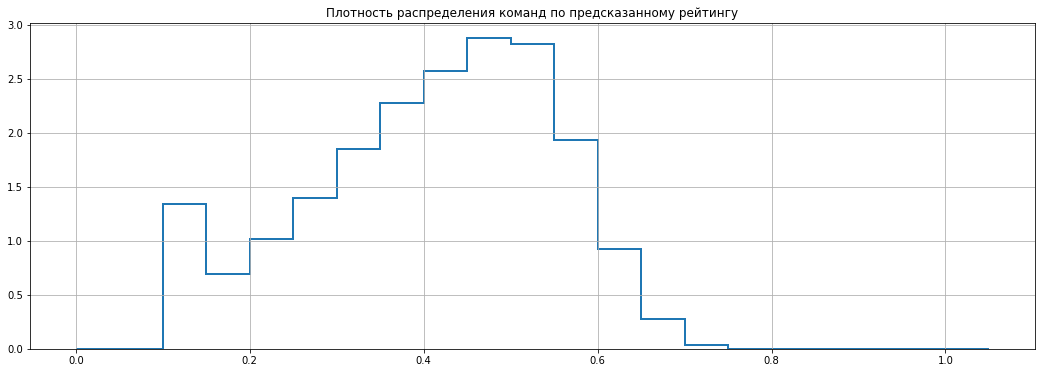

In [19]:
# распределение команд по предсказанному рейтингу
plt.figure(figsize=(18, 6))
plt.hist(team_rating.predicted_rating, 
         bins=np.arange(0, 1.1, 0.05), 
         histtype='step',
         cumulative=False,
         density=True,
         linewidth=2
        );
plt.title("Плотность распределения команд по предсказанному рейтингу")
plt.grid(True)
plt.show()

In [20]:
%%time
q_complexities = []
for tournament_id, group in tqdm(team_rating.groupby('tournament_id')):
    # print(group['mask'].str.len().min())
    for q_number in range(1,  group['mask'].str.len().min() + 1):
        q_complexity = group.loc[group['mask'].apply(lambda x: x[q_number - 1] == '1')].predicted_rating.mean()
        q_complexities.append((tournament_id, q_number, q_complexity))

q_complexities = pd.DataFrame(q_complexities, columns=['tournament_id', 'q_number', 'q_complexity'])

q_complexities.to_csv("q_complexities.csv", index=False)

100%|████████████████████████████████████████████████████████████████████████████████| 675/675 [00:19<00:00, 34.53it/s]


Wall time: 19.7 s


##  Способ ранжирования команд на основе рейтинга игроков

- рейтинг игрока по baseline-модели - оценка вероятности, что команда этого игрока правильно ответит на этот вопрос
- возьмём числовые характеристики рейтингов игроков в команде (среднее, медиана, процентили) и обучим модель на этих рейтингах


__предпосылки:__
- рейтинг игроков якобы не содержит информации о целевой переменной (несмотря на, то, что предпосылка нарушается можно сказать, что рейтинг игроков содержит мало информации о результате конкретной игры и попробовать обучить веса логистической регрессии на характеристиках распределения (min, max, avg, квантили) рейтингов игроков в команде)

### Возьмём модель для baseline и обучим вторую модель поверх её предсказаний

In [21]:
train_df = pd.read_csv("train_df.csv")
test_df = pd.read_csv("test_df.csv")

with open("train_X_y.pkl", "rb") as f:
    X_train, y_train, X_y_meaning = pickle.load(f)

with open("test_X_y.pkl", "rb") as f:
    X_test, y_test_prob = pickle.load(f)
    
with open("baseline_model.pkl", "rb") as f:
    model = pickle.load(f)
    
features = ['tours_num',
            'avg_pct_answered',
            'min_pct_answered',
            'max_pct_answered',
            'pct_answered_q_10',
            'pct_answered_q_90',
            'pct_answered_q_50']

def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = f"percentile_{n}"
    return percentile_

In [22]:
# q_complexities = pd.read_csv("q_complexities.csv")

In [23]:
def add_features(df, model):
    """посчитать предсказания модели на игроках из df"""
    prediction = model.predict_proba(df[features].fillna(0))[:, 1]
    train_to_aggregate_personal_ratings = df[['player', 'tournament_id', 'team_id']].copy()
    train_to_aggregate_personal_ratings.loc[:, 'player_rating'] = prediction

    train_by_team = train_to_aggregate_personal_ratings[['player',
                                                         'tournament_id',
                                                         'team_id',
                                                         'player_rating']].drop_duplicates()\
        .groupby(["team_id",
                  "tournament_id"]).player_rating.agg([
                      'min',
                      'max',
                      'mean',
                      percentile(10),
                      percentile(90)
                  ]
    )

    train_by_team.columns = ["agg_by_team_" + i for i in train_by_team.columns]
    return train_by_team

def get_train_sample(train_by_team, train_df):
    # развернём DataFrame вдоль маски
    to_ravel = train_df[['team_id', 'tournament_id', 'mask']].drop_duplicates()
    to_ravel_along = [np.array([int(j) for j in i if re.match("\d", j)], dtype=np.int) for i in to_ravel['mask']]

    def ravel_df_values(df_to_ravel: pd.DataFrame, values_to_ravel_along: List[np.array]):
        mask_lengths = [len(j) for j in values_to_ravel_along]

        raveled_values = \
        np.hstack(
            [
                np.vstack(
                    [np.tile(row[:-1], (mask_lengths[item_number] , 1))
                        for item_number, row in enumerate(df_to_ravel.values)
                    ]
                ),
                np.hstack(values_to_ravel_along).reshape(-1, 1)
            ]   
        )
        return raveled_values

    raveled_df = ravel_df_values(to_ravel, to_ravel_along)
    raveled_df = pd.DataFrame(raveled_df, columns = ['team_id', 'tournament_id', 'target'])

    train_by_team = \
    pd.merge(train_by_team, raveled_df.set_index(['team_id', 'tournament_id']),
                                                how='inner',
            left_index=True,
            right_index=True)
    return train_by_team

# def add_prob_target(df, ):
#     df.loc[:, 'prob_target'] = df.groupby(['team_id', 'tournament_id'])[['target']].mean()
#     return df


train_by_team = add_features(train_df, model)
train_by_team = get_train_sample(train_by_team, train_df)

In [24]:
test_by_team = add_features(test_df, model)

In [25]:
test_by_team.loc[:, 'prob_target'] = test_df.groupby(['team_id', 'tournament_id'])[['target']].mean()

In [26]:
model2 = LogisticRegression(C=0.01, penalty='l2', solver='saga')
model2.fit(
    train_by_team.drop(columns=['target']).values,
    train_by_team['target'].values.astype(int)
)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [27]:
print("Coefficients:", model2.coef_)
print("Intercept:", model2.intercept_)

Coefficients: [[-0.38802491  0.82686025  1.54717485  0.30835788  1.21084941]]
Intercept: [-1.84457221]


In [28]:
y_test_prob.shape

(112841,)

In [29]:
test_model_prediction = model2.predict_proba(test_by_team.drop(columns=['prob_target']))[:, 1]

In [30]:
merged = \
pd.merge(
pd.DataFrame(test_model_prediction.reshape(-1, 1), index=test_by_team.index, columns=['Prediction']),
test_df.groupby(['tournament_id', 'team_id']).target.mean().to_frame().rename(columns={'target': 'Actual_result'}),
    how='inner',
    left_index=True,
    right_index=True)

merged = merged.reset_index().sort_values(by=['tournament_id', 'Actual_result'], ascending=[True, False])
merged.loc[:, 'Actual_place_in_tournament'] = merged.groupby('tournament_id').team_id.cumcount() + 1

In [31]:
merged = merged.sort_values(by=['tournament_id', 'Prediction'], ascending=[True, False])
merged.loc[:, 'predicted_place_in_tournament'] = merged.groupby('tournament_id').team_id.cumcount() + 1

In [32]:
print(
"Спирмен: ",
spearmanr(merged['predicted_place_in_tournament'], 
          merged['Actual_place_in_tournament']), "\n",
"Кендалл: ",
kendalltau(merged['predicted_place_in_tournament'], 
          merged['Actual_place_in_tournament']), "\n"
, sep="")

Спирмен: SpearmanrResult(correlation=0.8567137800219694, pvalue=0.0)
Кендалл: KendalltauResult(correlation=0.6932473181210744, pvalue=0.0)



## Предсказание по EM-алгоритму

Для EM-алгоритма используем альтернативный подход для обработки данных - будем обучать логистическую регрессию в пространстве бинарных признаков вида игрок-вопрос. Этот подход требует переобучать модель каждый раз при добавлении новой команды/игрока, поэтому в baseline-модели он не использовался.

В качестве скрытой переменной z будем использовать переменную с бинарными значениями [0, 1] для каждой пары игрок-вопрос определяемую следующим образом:
- z = 0 если никто из команды этого игрока (включая самого игрока) не ответил на вопрос
- z = 1 если есть хотя бы один игрок в команде ответившил на этот вопрос

Следовательно, на E-шаге считаем ожидание E[z], считая что $P(z_{iq}=1) = \frac{\sigma(x)}{1 - \prod_{j\in{team}}{(1 - \sigma(x))}}$

### Предобработка для EM-алгоритма

In [33]:
%%time
START_MIN_QUESTION_NUMBER = 1000

def get_tournaments_id_for_year(year, tournaments, results):
    this_year_tournaments = [value for key, value in tournaments.items() if value['dateStart'][:4] == str(year)]
    tournaments_needed = [i for i in this_year_tournaments \
                          if i['id'] in results and results[i['id']] != [] and 'mask' in results[i['id']][0]]
    return [i['id'] for i in tournaments_needed]

def create_table(tournament_ids, results):
    for_table = []
    global_question_id = 0
    
    for t_id, t_data in results.items():
        if t_id in tournament_ids:
            min_number_of_questions = START_MIN_QUESTION_NUMBER
            for team in t_data:
                if 'mask' in team and team['mask'] != None:
                    if len(team['mask']) < min_number_of_questions:
                        min_number_of_questions = len(team['mask'])
            
            for team in t_data:
                if 'mask' in team and team['mask'] != None:
                    q_answered = 0
                    for answer in str(team['mask']):
                        if answer in ['0', '1']:
                            q_answered += int(answer)
                    
                    team_id = team['team']['id']
                    for member in team['teamMembers']:
                        member_id = member['player']['id']
                        for question_num in range(min_number_of_questions):
                            answer = team['mask'][question_num]
                            if answer in ['0', '1']:
                                for_table.append([t_id, 
                                                  team_id, 
                                                  member_id, 
                                                  question_num,
                                                  int(answer),
                                                  q_answered,
                                                  global_question_id + question_num])
                
            # для каждого турнира добавить число использованных вопросов для global_question_id
            global_question_id += min_number_of_questions
                                
    return pd.DataFrame(for_table, columns=['tournament_id', 'team_id', 'member_id', 
                                            'q_num', 'answer', 'q_answered',
                                            'global_question_id'])

with open("tournaments.pkl", 'rb') as f:
    tournaments = pickle.load(f)
    
with open("results.pkl", 'rb') as f:
    results = pickle.load(f)

train_tournaments_ids =  get_tournaments_id_for_year(2019, tournaments, results)
test_tournaments_ids =  get_tournaments_id_for_year(2020, tournaments, results)

train_df = create_table(train_tournaments_ids, results)
test_df = create_table(test_tournaments_ids, results)
del results
del tournaments

Wall time: 1min 15s


In [34]:
# сделать X_train, y_train
from sklearn.preprocessing import OneHotEncoder
one_hot_enc = OneHotEncoder(handle_unknown='ignore')
X_train = one_hot_enc.fit_transform(train_df[['member_id', 'global_question_id']])
y_train = np.array(train_df['answer'], dtype=np.int32)
train_feature_names = one_hot_enc.get_feature_names()

In [35]:
# сделать X_test, y_test
X_test = one_hot_enc.transform(test_df[['member_id', 'global_question_id']])
y_test = np.array(test_df['answer'], dtype=np.int32)

In [36]:
len(one_hot_enc.categories_[0]) + len(one_hot_enc.categories_[1])

90909

In [37]:
# игрок X вопрос
train_df[['member_id', 'global_question_id']].drop_duplicates().shape

(17913374, 2)

### EM - алгоритм (реализация)

In [38]:
import logging

def create_logger():
    logger = logging.getLogger("my_logger")
    logger.setLevel(logging.DEBUG)
    logger.handlers = []
    formatter = logging.Formatter('%(levelname)s - %(message)s')
    handler = logging.StreamHandler()
    handler.setFormatter(formatter)
    logger.addHandler(handler)
    return logger

logger = create_logger()

In [39]:
%%time

logger.setLevel(logging.INFO)

class EM:
    def __init__(self, learning_rate = 1, iterations = 10):
        self.learning_rate = learning_rate
        self.iterations = iterations
    
    def _get_question_probability(self, q_id):
        row_num = q_id
        result = expit(self.X[row_num] @ self.W + self.b)[0][0]
        return result
    
    def _E_step(self, data):
        self.team_results.loc[:, 'question_prob'] = self.team_results.apply(lambda x: \
                                                        self._get_question_probability(x['global_question_id']), 
                                                                       axis=1
                                                                        )
        # аггрегация по команде
        self.team_results.loc[:, 'team_prob'] =  self.team_results.groupby(['team_id', 
                                                                          'global_question_id'])['question_prob'].\
            transform(lambda x: np.prod(1 - x))
        self.team_results.loc[:, 'team_prob'] = self.team_results.groupby('team_prob').apply(lambda x: 1 - x)
        
        self.Z = (self.team_results['question_prob'] / self.team_results['team_prob']).to_numpy()
        self.Z[self.Y == 0] = 0    
        logger.debug("E-step done")
        
    def _M_step(self):
        A = expit(self.X.dot(self.W) + self.b) 
        tmp = (A - self.Z.T.reshape(A.shape)).reshape(-1, 1)
        
        dW = (self.X.T @ tmp) / self.n_records
        db = np.sum(tmp) / self.n_records
        
        self.W = self.W - self.learning_rate * dW    
        self.b = self.b - self.learning_rate * db
        logger.debug("M-step done")
        
        
    def fit(self, X, Y, data):
        self.n_records, self.n_features = X.shape
        
        self.W = np.zeros(self.n_features).reshape(-1, 1)
        self.b = 0
        self.X, self.Y, self.Z = X, Y, Y
        
        self.team_results = pd.DataFrame({'team_id': data['team_id'], 
                                          'global_question_id': data['global_question_id']
                                         })
        self.team_results['q_prob'] = self.Y
        self.team_results['t_prob'] = self.Y
        data['Z'] = self.Z
        
        for _ in range(self.iterations):
            self._E_step(data)
            self._M_step()
            logger.info(f"%s iterations done", _)
            
    def predict(self, X) :    
        temp = expit(X @ self.W + self.b)
        y_pred = np.where(temp > 0.5, 1, 0 )           
        return y_pred
    
    def predict_prob(self, X):
        return expit(X @ self.W + self.b)  

Wall time: 0 ns


In [51]:
%%time
# попробуем обучить модель на небольшой выборке из данных
n_sample = 100_000
toy_X = X_train[:n_sample].copy()
toy_y = y_train[:n_sample].copy()
toy_train_df = train_df.head(n_sample).copy()

em = EM(iterations=10)

em.fit(toy_X, toy_y, toy_train_df)

INFO - 0 iterations done
INFO - 1 iterations done
INFO - 2 iterations done
INFO - 3 iterations done
INFO - 4 iterations done
INFO - 5 iterations done
INFO - 6 iterations done
INFO - 7 iterations done
INFO - 8 iterations done
INFO - 9 iterations done


Wall time: 2min 46s


In [52]:
y_pred = em.predict_prob(X_test)

### EM-алгоритм (проверка)


In [53]:
# реальные результаты команды на турнире
actual_results = test_df.groupby(['tournament_id', 'team_id']).answer.mean().reset_index().rename(columns={'answer': 
                                                                                         'actual'})
actual_results = actual_results.sort_values(by=['tournament_id', 'actual'], ascending=[True, False])
actual_results.loc[:, 'actual_place'] = actual_results.groupby(['tournament_id']).actual.cumcount() + 1

In [54]:
# определим силу игроков
player_force_dict = {int(key.replace("x0_", "")): value[0] for key, value in zip(train_feature_names, em.W) if 'x0_' in key}

In [55]:
# предсказанные результаты команды на турнире
predicted_results = test_df.assign(player_force=test_df['member_id'].map(player_force_dict))
predicted_results = predicted_results.loc[predicted_results.player_force.notna()]

predicted_results = predicted_results.groupby(['tournament_id', 'team_id'])\
.player_force.max().reset_index().rename(columns={"player_force": 'predicted'})

predicted_results = predicted_results.sort_values(by=['tournament_id', 'predicted'], ascending=[True, False])
predicted_results.loc[:, 'predicted_place'] = predicted_results.groupby(['tournament_id']).predicted.cumcount() + 1

# сравнение
to_compare = \
pd.merge(actual_results[['tournament_id', 'team_id', 'actual_place']],
         predicted_results[['tournament_id', 'team_id', 'predicted_place']],
         how='inner', 
        left_on = ['tournament_id', 'team_id'],
        right_on = ['tournament_id', 'team_id']
        )

display(HTML("<h3> Результаты обучения на небольшой части данных по датасету игрок-вопрос:"))
print(
"Спирмен: ",
spearmanr(to_compare['predicted_place'], 
          to_compare['actual_place']), "\n",
"Кендалл: ",
kendalltau(to_compare['predicted_place'], 
          to_compare['actual_place']), "\n"
, sep="")

Спирмен: SpearmanrResult(correlation=0.6907987358231241, pvalue=0.0)
Кендалл: KendalltauResult(correlation=0.5159134441629591, pvalue=0.0)



## Рейтинг-лист турниров по сложности вопросов

Строим на основании EM - модели

In [56]:
question_complexity_dict = {int(key.replace("x1_", "")): value[0] for key, value in zip(train_feature_names, em.W) 
                            if 'x1_' in key
                           }

In [57]:
to_check = train_df.assign(q_complexity = train_df['global_question_id'].map(question_complexity_dict)
               )

In [58]:
top_10 = to_check.groupby('tournament_id').q_complexity.mean().sort_values(ascending=False).head(10).index
last_10 = to_check.groupby('tournament_id').q_complexity.mean().sort_values(ascending=True).head(10).index

In [59]:
with open("tournaments.pkl", 'rb') as f:
    tournaments_data = pickle.load(f)

In [60]:
display(HTML("<h3> Топ 10 турниров по сложности вопросов:"))
for t_id in top_10:
    print(tournaments_data[t_id]['name'])

ОВСЧ
36 мгновений весны в ЛЭТИ
Зеркало финала ОЧВР
Финал ОЧВР
Гран-при Текстильной столицы
Летний Синхронный Умлаут
Синхрон Моносова
Чемпионат Минска. Лига А. Тур четвёртый
Кубок Космонавтики
Зимний Братский Кубок "От Винта"


In [61]:
display(HTML("<h3> Топ 10 турниров по простоте вопросов:"))
for t_id in last_10:
    print(tournaments_data[t_id]['name'])

Синхрон северных стран. Зимний выпуск
Балтийский Берег. 3 игра
Белые ночи. The Best
Кубок княгини Ольги среди школьников
Открытый кубок МГУ
Блаженный Августинер
Кубок Москвы
Кубок Хэллоуина
Третья октава
Вторая октава
